# Question 4: Look at the Weights Repository- TensorFlowHub and Implement new models on 102 Oxford Flowers Dataset

Link: https://www.robots.ox.ac.uk/~vgg/data/flowers/102/



# **Deep Learning - CSE4006**
# LAB 5

> ## Name: **K CHARVI**
> ## Reg No: 19BCE7002
> ## Date: 27|10|2021
> ## Submitted To: Dr. BKSP Kumarraju Alluri


In [4]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import glob, os
import tarfile
import scipy.io
import PIL
from PIL import ImageOps, ImageFilter
from sklearn.model_selection import train_test_split


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd /content/drive/MyDrive/Deep learning LAB

/content/drive/MyDrive/Deep learning LAB


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR']='/content/drive/MyDrive/Deep learning LAB/'

In [ ]:
!kaggle datasets download -d demonplus/flower-dataset-102

 98% 321M/329M [00:03<00:00, 96.8MB/s]
100% 329M/329M [00:03<00:00, 106MB/s] 


In [ ]:
!unzip flower-dataset-102.zip


Archive:  flower-dataset-102.zip
  inflating: 102flowers.tgz          
  inflating: imagelabels.mat         


In [2]:
%cd /content/drive/MyDrive/Deep learning LAB/flowers 102

[Errno 2] No such file or directory: '/content/drive/MyDrive/Deep learning LAB/flowers 102'
/content


In [6]:
IMG_SIZE = 224
IMG_CHANNELS = 3
input_shape = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = '/content/drive/MyDrive/Deep learning LAB/flowers 102/'
PATH = '/content/drive/MyDrive/Deep learning LAB/flowers 102/flowers/'

In [7]:
# Get all the data from the archive files in the directory
def get_filenames(tgz):
    with tarfile.open(tgz) as file:
        return[i.name for i in file.getmembers() if i.isfile()]


df = pd.DataFrame()
df['Id'] = sorted(get_filenames(DATA_PATH + '102flowers.tgz'))
df['Category'] = scipy.io.loadmat(DATA_PATH + 'imagelabels.mat')['labels'][0] - 1 # classes for earch 0,..,N
df['Category'] = df['Category'].astype('str')

# Explore if everything is ok
df.head(4)

,Id,Category
0,jpg/image_00001.jpg,76
1,jpg/image_00002.jpg,76
2,jpg/image_00003.jpg,76
3,jpg/image_00004.jpg,76


In [ ]:
# Unzipping the images that are in the dataset
opened_tgz = tarfile.open(DATA_PATH + "102flowers.tgz")
opened_tgz.extractall(PATH)

# Check the files
print(os.listdir(PATH + 'jpg')[:12])

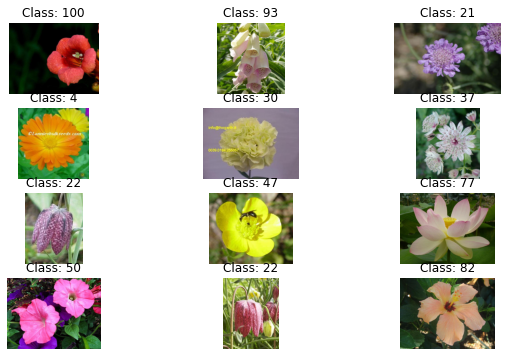

In [ ]:
# Example of the images that dataset contains
plt.figure(figsize = (10, 6))

random_image = df.sample(n = 12)
random_image_paths = random_image['Id'].values
random_image_category = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    ax = PIL.Image.open(PATH + path)
    plt.subplot(4, 3, index + 1)
    plt.imshow(ax)
    plt.title("Class: " + str(random_image_category[index]))
    plt.axis("off")

plt.show();

In [9]:
# train/test splitting
X_train, X_test, y_train, y_test = train_test_split(df['Id'], df['Category'], test_size = 0.2, stratify = df['Category'])

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

X_train['Category'] = y_train
X_test['Category'] = y_test

print(f"Shape of the Train Data: {X_train.shape}\nShape of the Test Data: {X_test.shape}")

Shape of the Train Data: (6551, 2)
Shape of the Test Data: (1638, 2)


In [10]:
# Augmentation is very important part when you do not have a big data to train the model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1. / 255,
                                   rotation_range = 50, shear_range = 0.2,
                                   zoom_range = [0.75, 1.25],
                                   brightness_range = [0.5, 1.5],
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1. / 255)

In [11]:
# Wrapping all data to the generator
BATCH_SIZE = 10
train_generator = train_datagen.flow_from_dataframe(dataframe = X_train, directory = PATH, x_col = 'Id', y_col = "Category",
                                                    target_size = (IMG_SIZE, IMG_SIZE), batch_size = BATCH_SIZE, class_mode = 'categorical',
                                                    shuffle = True, seed = 42)

test_generator = test_datagen.flow_from_dataframe(dataframe = X_test, directory = PATH, x_col = 'Id', y_col = "Category", 
                                                  target_size = (IMG_SIZE, IMG_SIZE), batch_size = BATCH_SIZE, class_mode = 'categorical',
                                                 shuffle = False, seed = 42)

Found 6551 validated image filenames belonging to 102 classes.
Found 1638 validated image filenames belonging to 102 classes.


Image Train example:


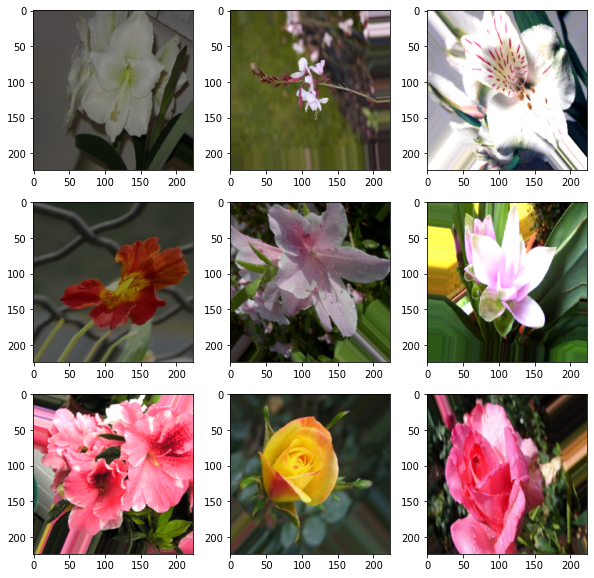

In [ ]:
from skimage import io

def imshow(image):
    io.imshow(image)
    io.show()
    
x, y = train_generator.next()
print("Image Train example:")
plt.figure(figsize = (10, 10))

for i in range(0, 9):
    image = x[i]
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)

plt.show();

In [12]:
!pip install "tensorflow>=1.7.0"
!pip install tensorflow-hub


In [20]:
# Import dependencies 
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
IMG_SHAPE=(224,224)
BATCH_SIZE=32

In [21]:
# Let's make a create_model() function to create a model from a URL
def create_model(model_url):

  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the already learned patterns
                                           name="feature_extraction_layer",
                                           input_shape=IMG_SHAPE+(3,)) 

  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(102, activation="softmax", name="output_layer")
  ])
    
  return model  

In [26]:
# Model's URL from tensorflow hub

resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

inception_v3_url = "https://tfhub.dev/google/imagenet/inception_v3/classification/5"

In [27]:
# Building , compiling & fitting our EfficientNet Model

eff_model=create_model(efficientnet_url)

eff_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

eff_model = eff_model.fit(train_generator,
                                  epochs=1,
                                  steps_per_epoch=len(train_generator),
                                  validation_data=test_generator,
                                  validation_steps=len(test_generator))

656/656 [==============================] - 3915s 6s/step - loss: 1.8347 - accuracy: 0.6387 - val_loss: 0.7877 - val_accuracy: 0.8303


In [ ]:
# Building , compiling & fitting our Inception Model

incept_model=create_model(inception_v3_url)

incept_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

incept_ =history resnet_model.fit(train_generator,
                                  epochs=1,
                                  steps_per_epoch=len(train_generator),
                                  validation_data=test_generator,
                                  validation_steps=len(test_generator))

In [ ]:
# Building , compiling & fitting our Resnet Model

res_model=create_model(resnet_url)

res_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

res_his =history resnet_model.fit(train_generator,
                                  epochs=1,
                                  steps_per_epoch=len(train_generator),
                                  validation_data=test_generator,
                                  validation_steps=len(test_generator))

### Another Way to do it: its not embedded in a function


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
m = tf.keras.Sequential([hub.KerasLayer("https://tfhub.dev/tensorflow/resnet_50/classification/1",trainable=False),
tf.keras.layers.Dense(102, activation='softmax')
])
m.build([None, 224, 224, 3])  # Batch input shape.



In [ ]:
m.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 1001)              25612201  
_________________________________________________________________
dense_2 (Dense)              (None, 102)               102204    
Total params: 25,714,405
Trainable params: 102,204
Non-trainable params: 25,612,201
_________________________________________________________________


In [ ]:
m.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True,
    name='categorical_crossentropy' ),
  metrics=['accuracy'])

In [ ]:
#training
BATCH_SIZE = 10
hist = m.fit(
    train_generator,
    validation_data=test_generator,
    epochs=2
    ).history


Epoch 1/2
656/656 [==============================] - ETA: 0s - loss: 4.5661 - accuracy: 0.0437

/usr/local/lib/python3.7/dist-packages/keras/backend.py:4847: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


656/656 [==============================] - 1039s 2s/step - loss: 4.5661 - accuracy: 0.0437 - val_loss: 4.5209 - val_accuracy: 0.0549
Epoch 2/2
656/656 [==============================] - 1052s 2s/step - loss: 4.4987 - accuracy: 0.0521 - val_loss: 4.4687 - val_accuracy: 0.0525


#### Though the accuracy in this modelling has been bad, but the crux of this question is achieved
